# Deep Learning With Python: 5.4

**Introdução a Deep Learning | Aplicações em Visão Computacional**

<br>

---

## Tópico Abordado

* Visualizing what convnets learn

---

# Visualização 👀

## Cobertura
* Visualização de ativadores intermediários
* Visualização dos filtros de uma convnet
* Vizualização dos *heatmaps* das classes de ativação em uma imagem

In [0]:
# All imports

import os
import numpy as np
import random
import tensorflow as tf
from keras import backend as K

import shutil
from google.colab import drive
import zipfile

import matplotlib.pyplot as plt

from keras.preprocessing import image

from keras import models
from keras import layers
from keras import optimizers

from keras.callbacks import CSVLogger
import pandas as pd

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

import cv2

from time import time

In [0]:
# Reprodutibilidade
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

os.environ['PYTHONHASHSEED'] = '12'
np.random.seed(123)
random.seed(1234)
tf.set_random_seed(12345)

# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
#                               inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

print('Sementes Plantadas!')

Sementes Plantadas!


In [0]:
# Montando Google Drive

drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
class DataHandler:
  def __init__(self, folder):
    self.source_file = '/gdrive/My Drive/ml_datasets/dogs_vs_cats.zip'
    self.root_dir = '/content/data'
    self.base_dir = os.path.join(self.root_dir, folder)
    self.train_dir = os.path.join(self.base_dir, 'train')
    self.train_cats_dir = os.path.join(self.train_dir, 'cats')
    self.train_dogs_dir = os.path.join(self.train_dir, 'dogs')
    self.val_dir = os.path.join(self.base_dir, 'validation')
    self.val_cats_dir = os.path.join(self.val_dir, 'cats')
    self.val_dogs_dir = os.path.join(self.val_dir, 'dogs')
    self.test_dir = os.path.join(self.base_dir, 'test')
    self.test_cats_dir = os.path.join(self.test_dir, 'cats')
    self.test_dogs_dir = os.path.join(self.test_dir, 'dogs')
  
  def __config_dir_struct(self):
    if (not os.path.exists(self.root_dir)):
      os.mkdir(self.root_dir)

    try:
      shutil.rmtree(self.base_dir)
      print('Diretório de dados limpo')
    except:
      pass

    os.mkdir(self.base_dir)
    os.mkdir(self.train_dir)
    os.mkdir(self.train_cats_dir)
    os.mkdir(self.train_dogs_dir)
    os.mkdir(self.val_dir)
    os.mkdir(self.val_cats_dir)
    os.mkdir(self.val_dogs_dir)
    os.mkdir(self.test_dir)
    os.mkdir(self.test_cats_dir)
    os.mkdir(self.test_dogs_dir)

  def extract(self, train_samples=0, val_samples=0, test_samples=0):
    self.__config_dir_struct()
    self.train_samples = train_samples
    self.val_samples = val_samples
    self.test_samples = test_samples

    def move_to_parent(root, child):
      for f in os.listdir(os.path.join(root, child)):
        shutil.move(
            os.path.join(root, child, f),
            root
        )
      os.rmdir(os.path.join(root, child))

    print('Iniciando descompressões')

    if (not os.path.exists(os.path.join(self.root_dir, 'train.zip'))):
      with zipfile.ZipFile(self.source_file, 'r') as zip_ref:
        zip_ref.extract('train.zip', path=self.root_dir)
        print('Conjunto de treinamento OK!')

    with zipfile.ZipFile(os.path.join(self.root_dir, 'train.zip'), 'r') as zip_ref:
      start = 0
      end = train_samples
      for i in range(start, end):
        zip_ref.extract('train/cat.{}.jpg'.format(i), path=self.train_cats_dir)
        zip_ref.extract('train/dog.{}.jpg'.format(i), path=self.train_dogs_dir)
      move_to_parent(self.train_cats_dir, 'train')
      move_to_parent(self.train_dogs_dir, 'train')
      print('Subconjunto de treinamento OK!')
      
      start = end
      end = train_samples + val_samples
      for i in range(start, end):
        zip_ref.extract('train/cat.{}.jpg'.format(i), path=self.val_cats_dir)
        zip_ref.extract('train/dog.{}.jpg'.format(i), path=self.val_dogs_dir)
      move_to_parent(self.val_cats_dir, 'train')
      move_to_parent(self.val_dogs_dir, 'train')
      print('Subconjunto de validação OK!')

      start = end
      end = train_samples + val_samples + test_samples
      for i in range(start, end):
        zip_ref.extract('train/cat.{}.jpg'.format(i), path=self.test_cats_dir)
        zip_ref.extract('train/dog.{}.jpg'.format(i), path=self.test_dogs_dir)
      move_to_parent(self.test_cats_dir, 'train')
      move_to_parent(self.test_dogs_dir, 'train')
      print('Subconjunto de teste OK!')
      
  def get(self, subset='train', sample_class='cat', sample_num=0):
    if (subset == 'train'):
      path = self.train_cats_dir if sample_class == 'cat' else self.train_dogs_dir
    elif (subset == 'val'):
      path = self.val_cats_dir if sample_class == 'cat' else self.val_dogs_dir
    else:
      path = self.test_cats_dir if sample_class == 'cat' else self.test_dogs_dir

    return '{}/{}.{}.jpg'.format(path, sample_class, str(sample_num))

In [0]:
dh = DataHandler('ss1000')
dh.extract(1000, 500, 500)

Diretório de dados limpo
Iniciando descompressões
Subconjunto de treinamento OK!
Subconjunto de validação OK!
Subconjunto de teste OK!


In [0]:
get_path = lambda f: '/gdrive/My Drive/ml_fits/{}'.format(f)

m = models.load_model(get_path('cats_dogs_subset1000.h5'))
m.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)      

In [0]:
def img_to_tensor(path):
  img = image.load_img(path, target_size=(150, 150))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  
  return img_tensor

In [0]:
def export(name):
  path = '/gdrive/My Drive/colab_output/ch5.4/{}_{}.pdf'.format(
      str(int(time())), name)
  plt.savefig(path, bbox_inches = 'tight')

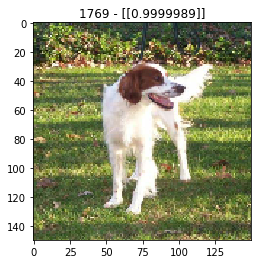

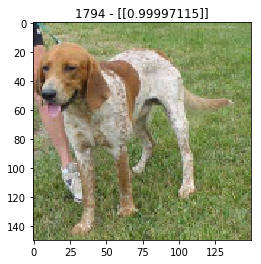

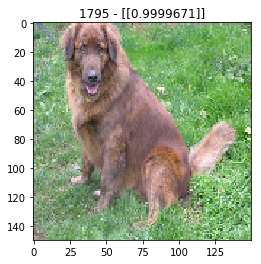

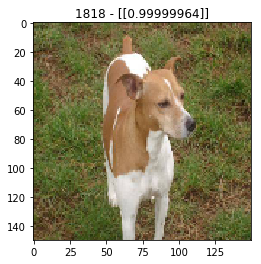

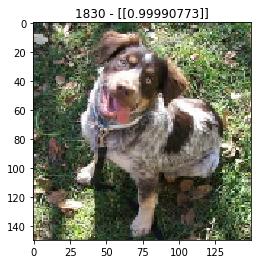

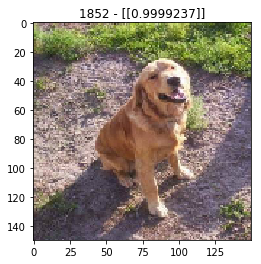

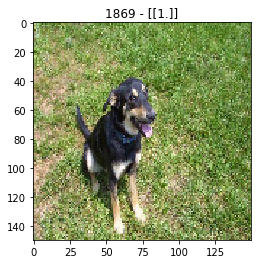

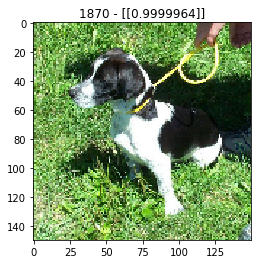

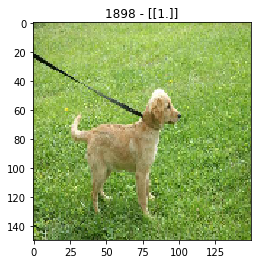

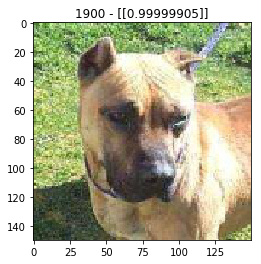

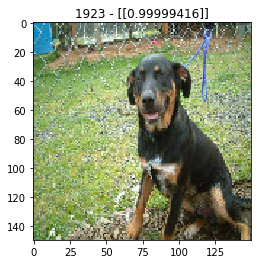

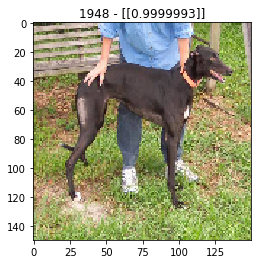

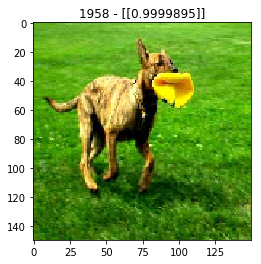

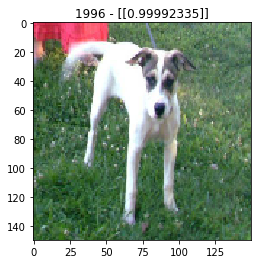

In [0]:
# mx = models.load_model('/gdrive/My Drive/ml_fits/cats_dogs_subset1000.h5')
mx = m_aug

for i in range(1747, 1999):
  t = img_to_tensor(dh.get('test', 'dog', i))
  p = mx.predict(t)
  if (p > 0.9999):
    plt.imshow(t[0])
    plt.title(str(i) + ' - ' + str(p))
    plt.show()

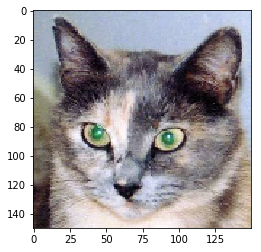

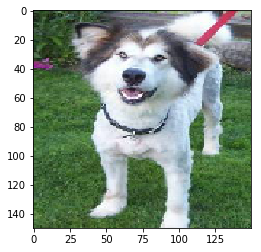

In [0]:
img_tensor1 = img_to_tensor(dh.get('test', 'cat', 1700))
img_tensor2 = img_to_tensor(dh.get('test', 'dog', 1880))

plt.imshow(img_tensor1[0])
export('cat')
plt.show()

plt.imshow(img_tensor2[0])
export('dog')
plt.show()

In [0]:
def get_activations(model, img_tensor):
  layer_outputs = [layer.output for layer in model.layers[:8]]
  activation_model = models.Model(inputs=m.input, outputs=layer_outputs)
  activations = activation_model.predict(img_tensor)
  return activations

activations1 = get_activations(m, img_tensor1)
activations2 = get_activations(m, img_tensor2)

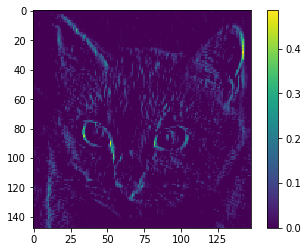

In [0]:
plt.imshow(activations1[0][0, :, :, 21], cmap='viridis')
plt.colorbar()
export('cat')
plt.show()

plt.imshow(activations2[0][0, :, :, 21], cmap='viridis')
plt.colorbar()
export('dog')
plt.show()

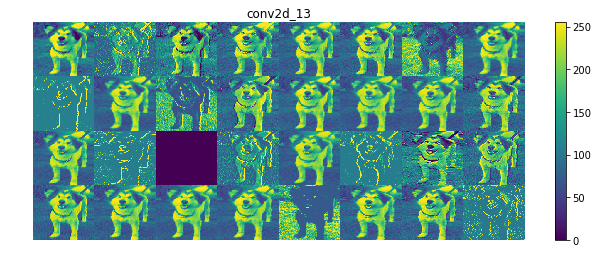

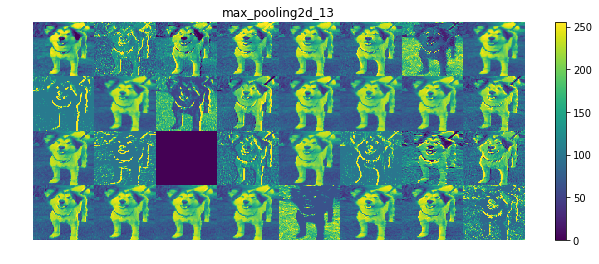

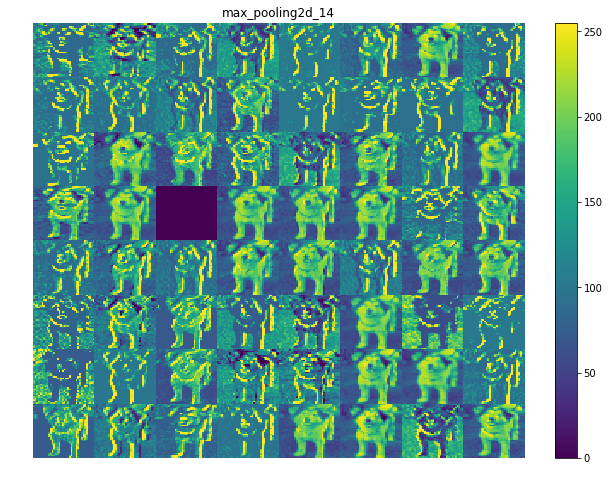

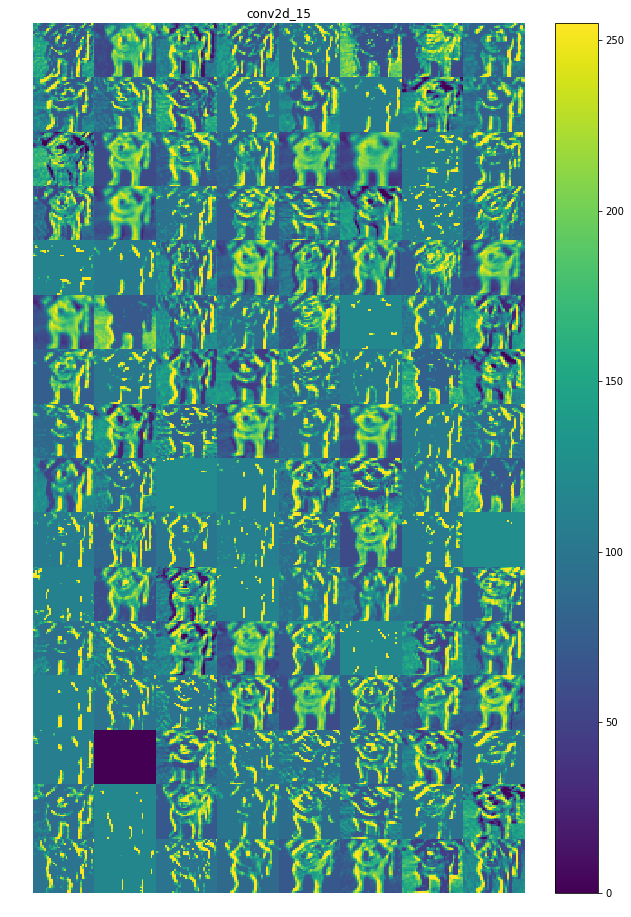

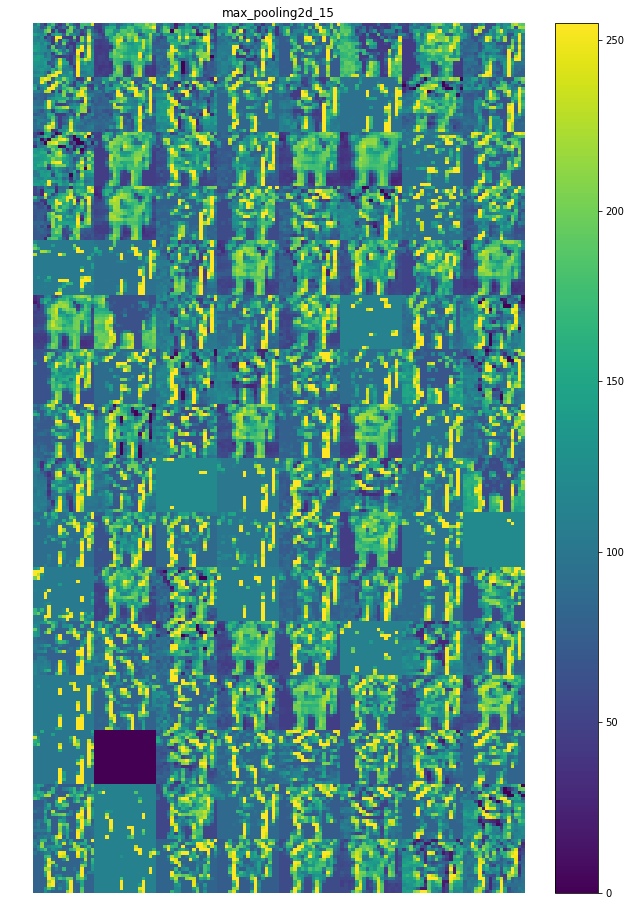

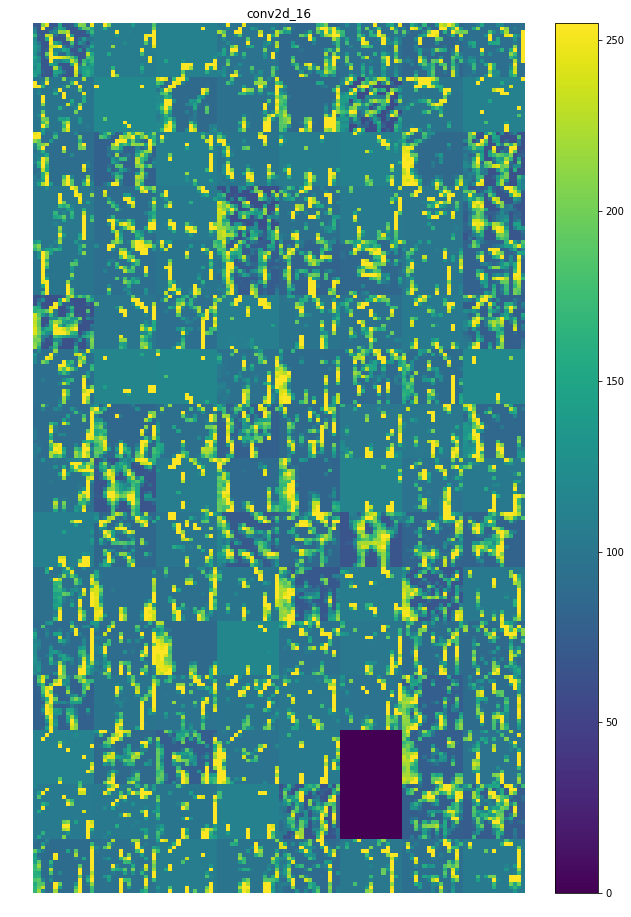

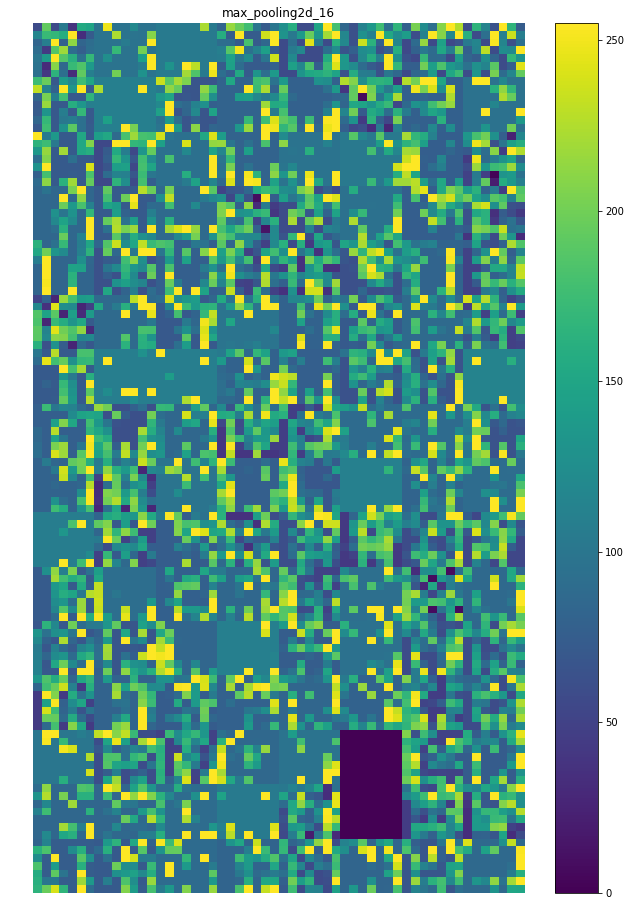

In [0]:
layer_names = [layer.name for layer in m.layers[:8]]
images_per_row = 8

def get_image_grid(layer):
  images_per_row = 8
  n_features = layer.shape[-1]
  size = layer.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0,
                                        :, :,
                                        col * images_per_row + row]

      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size,
                    row * size : (row + 1) * size] = channel_image
  
  return display_grid

def plot_grid(grid, size):
  scale = 1. / size
  plt.figure(figsize=(scale * grid.shape[1],
                    scale * grid.shape[0]))

  # plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='plasma')


# g = get_image_grid(activations1[6])
# plot_grid(g, activations1[6].shape[1])



for layer_name, layer_activation in zip(layer_names, activations2):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0,
                                        :, :,
                                        col * images_per_row + row]

      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size,
                    row * size : (row + 1) * size] = channel_image

  display_grid = get_image_grid(layer_activation)
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1] + 3,
  scale * display_grid.shape[0]))

  plt.title(layer_name)
  plt.grid(False)
  plt.axis('off')
  plt.imshow(display_grid, aspect='auto', cmap='viridis')
  plt.colorbar()
  export(layer_name)
  plt.show()

In [0]:
# vgg_model = VGG16(weights='imagenet', include_top=False)
# vgg_model = m
# vgg_model = mx
# layer_name = 'block3_conv1'
# filter_index = 0
# layer_output = vgg_model.get_layer(layer_name).output
# loss = K.mean(layer_output[:, :, :, filter_index])

In [0]:
def deprocess_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1
  x += 0.5
  x = np.clip(x, 0, 1)
  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
def generate_pattern(layer_name, filter_index, size=150):
  layer_output = vgg_model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])
  grads = K.gradients(loss, vgg_model.input)[0]
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
  iterate = K.function([vgg_model.input], [loss, grads])
  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
  step = 1.
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
  img = input_img_data[0]
  return deprocess_image(img)

In [0]:
def filters_grid(label_name, filters_num, plot_per_row=8, plot_size=1.5):
  plot_num = filters_num
  plot_rows = np.ceil(plot_num / plot_per_row)
  padding = 0.01
  w = plot_per_row * (padding + plot_size)
  h = plot_rows * (0.02 + plot_size)
  fig = plt.figure(figsize=(w, h))
  fig.subplots_adjust(wspace=0.015, hspace=0.015)

  for i in range(plot_num):
    ax = fig.add_subplot(plot_rows, plot_per_row, i + 1)
    ax.imshow(generate_pattern(label_name, i))
    ax.axis('off')

  export(label_name + '_' + str(filters_num))
  fig.show()

In [0]:
vgg_model = VGG16(weights='imagenet', include_top=False)
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

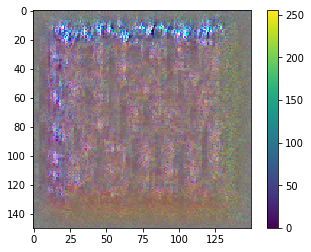

In [0]:
vgg_model = m

plt.imshow(generate_pattern('conv2d_16', 25))
plt.colorbar()
export('m16_conv2d_26')
plt.show()
# plt.imshow(generate_pattern('block3_conv3', 128))
# plt.show()
# plt.imshow(generate_pattern('block3_pool', 128))
# plt.show()
# plt.imshow(generate_pattern('conv2d_15', 0))

In [0]:
vgg_model = m
# vgg_model.summary()
filters_grid('conv2d_13', 32)

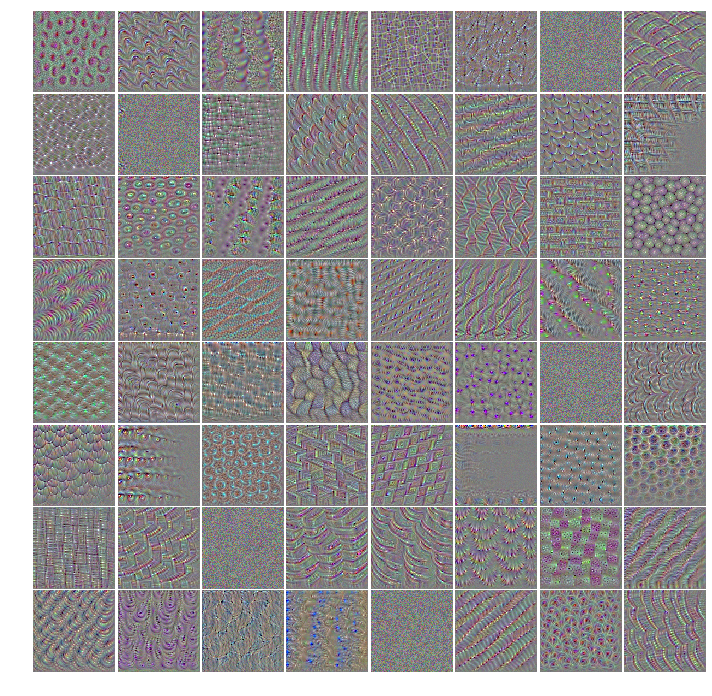

In [0]:
vgg_model = VGG16(weights='imagenet', include_top=False)
filters_grid('block4_conv1', 64)

In [0]:
m_aug = models.load_model('/gdrive/My Drive/ml_fits/cats_dogs_aug.h5')
m_full = models.load_model('/gdrive/My Drive/ml_fits/cats_dogs_full.h5')
vgg = VGG16(weights='imagenet', include_top=False)

In [0]:
# vgg_model2 = VGG16(weights='imagenet')
# img_path = '/gdrive/My Drive/ml_datasets/cc_elephant.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
aux = ['conv2d_16', 'conv2d_28', 'conv2d_20', 'block5_conv3'] # m, aug, full, vgg
vgg_model2 = m_aug
last_conv_name = aux[1]

img_path = dh.get('test', 'dog', 1769)
img = image.load_img(img_path, target_size=(150,150))
###
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

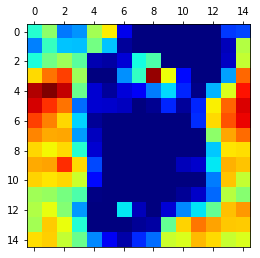

In [0]:
x = img_to_tensor(img_path)

preds = vgg_model2.predict(x)

img_output = vgg_model2.output[:, np.argmax(preds[0])]
last_conv_layer = vgg_model2.get_layer(last_conv_name)
grads = K.gradients(img_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([vgg_model2.input],
                      [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(128):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

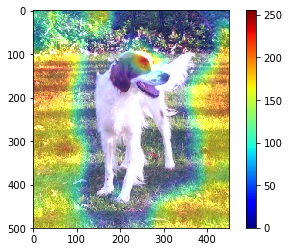

In [0]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
out_path = '/content/heatmap.png'
cv2.imwrite(out_path, superimposed_img)
img = image.load_img(out_path)
plt.imshow(img)
plt.set_cmap('jet')
plt.colorbar()
export('heatmap_' + last_conv_name)
plt.show()

In [0]:
m_full.predict(x)

array([[0.99669063]], dtype=float32)